In [70]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn import preprocessing
import tensorflow as tf
from sklearn.metrics import accuracy_score
from collections import Counter
import sklearn

# Baseline model

## Loading dataset

In [2]:
images = np.load('/content/drive/MyDrive/MaskDetection/images.npy')
labels = np.load('/content/drive/MyDrive/MaskDetection/labels.npy')

In [3]:
print(images.shape)

(9398, 80, 80, 3)


In [4]:
def make_preview(images, labels, n=25, len_per_image=2.6):
  sqrt_n = int(np.ceil(np.sqrt(n)))
  size = sqrt_n * len_per_image

  random_indices = np.random.choice(len(labels), size=n, replace=False)

  plt.figure(figsize=(size, size))
  for i, idx in enumerate(random_indices):
      image = images[idx]
      label = labels[idx]
      
      plt.subplot(sqrt_n, sqrt_n, i+1)
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
  plt.show()

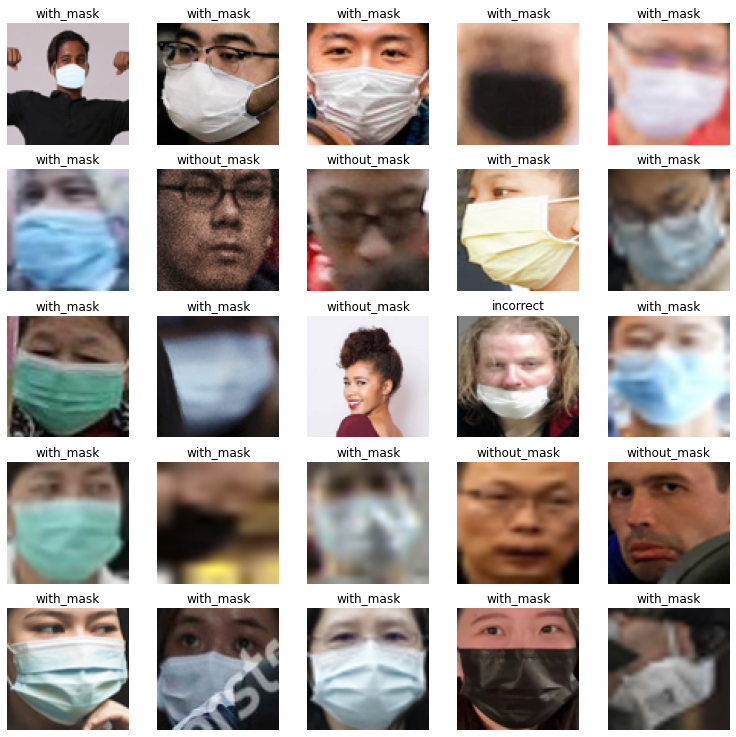

In [5]:
make_preview(images, labels)

## Splitting the data set into training and test data sets

In [6]:
# Divide dataset into classes
with_mask = np.where(labels == 'with_mask')
with_mask_data = images[with_mask]
with_mask_labels = labels[with_mask]

without_mask = np.where(labels == 'without_mask')
without_mask_data = images[without_mask]
without_mask_labels = labels[without_mask]

incorrect_mask = np.where(labels == 'incorrect')
incorrect_data = images[incorrect_mask]
incorrect_labels = labels[incorrect_mask]

In [7]:
print(len(with_mask_data), len(without_mask_data), len(incorrect_data))

6894 1984 520


In [8]:
def data_split(images, labels, test_size):
  if test_size < 1:
    test_size = int(len(images) * test_size)
  
  images, labels = shuffle(images, labels)
  X_test = images[:test_size]
  y_test = labels[:test_size]
  X_train = images[test_size:]
  y_train = labels[test_size:]

  return X_train, y_train, X_test, y_test

In [9]:
with_X_train, with_y_train, with_X_test, with_y_test = data_split(with_mask_data, with_mask_labels, 0.2)
print(len(with_X_train), len(with_X_test))

without_X_train, without_y_train, without_X_test, without_y_test = data_split(without_mask_data, without_mask_labels, 0.2)
print(len(without_X_train), len(without_X_test))

incorrect_X_train, incorrect_y_train, incorrect_X_test, incorrect_y_test = data_split(incorrect_data, incorrect_labels, 0.2)
print(len(incorrect_X_train), len(incorrect_X_test))

5516 1378
1588 396
416 104


In [12]:
X_train = np.concatenate([with_X_train, without_X_train, incorrect_X_train], axis=0)
y_train = np.concatenate([with_y_train, without_y_train, incorrect_y_train], axis=0)

X_test = np.concatenate([with_X_test, without_X_test, incorrect_X_test], axis=0)
y_test = np.concatenate([with_y_test, without_y_test, incorrect_y_test], axis=0)

vectorized_preprocess = np.vectorize(preprocess)
X_test_norm = vectorized_preprocess(X_test)

print(len(X_train), len(X_test))

7520 1878


In [ ]:
del with_X_train
del with_y_train
del with_X_test
del with_y_test

del without_X_train
del without_y_train
del without_X_test
del without_y_test

del incorrect_X_train
del incorrect_y_train
del incorrect_X_test
del incorrect_y_test

## Encoding labels

In [13]:
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [14]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

## Data Generator

In [11]:
def preprocess(image):
  return image / 127.5 - 1.0

In [15]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=20,
	  zoom_range=0.15,
	  width_shift_range=0.15,
	  height_shift_range=0.15,
	  shear_range=0.15,
	  horizontal_flip=True,
	  fill_mode="nearest",
    validation_split=0.2)

In [16]:
init_lr = 1e-4
epochs = 20
batch_size = 64
input_shape = (80,80,3)

In [17]:
train_gen = gen.flow(
x=X_train,
y=y_train,
subset="training",
batch_size=batch_size,
seed=42,
shuffle=True)

valid_gen = gen.flow(
x=X_train,
y=y_train,
subset="validation",
batch_size=batch_size,
seed=42,
shuffle=True)

In [18]:
step_size_train = train_gen.n//batch_size
step_size_valid = valid_gen.n//batch_size

## Simple model

In [ ]:
input = tf.keras.layers.Input(shape=input_shape)
out = tf.keras.layers.Conv2D(100, (3,3), activation='relu')(input)
out = tf.keras.layers.Conv2D(100, (3,3), strides=2, activation='relu')(input)
out = tf.keras.layers.Conv2D(100, (3,3), strides=2, activation='relu')(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dropout(0.5)(out)
out = tf.keras.layers.Dense(50, activation='relu')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)
model = tf.keras.models.Model(input, out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
#training
H = model.fit(
	train_gen,
	steps_per_epoch=step_size_train,
  validation_data = valid_gen,
  validation_steps = step_size_valid,
	epochs=epochs)

Epoch 1/20
94/94 [==============================] - 12s 124ms/step - loss: 0.5951 - acc: 0.7749 - val_loss: 0.1888 - val_acc: 0.9463
Epoch 2/20
94/94 [==============================] - 11s 122ms/step - loss: 0.3658 - acc: 0.8761 - val_loss: 0.1646 - val_acc: 0.9545
Epoch 3/20
94/94 [==============================] - 11s 121ms/step - loss: 0.3380 - acc: 0.8856 - val_loss: 0.2025 - val_acc: 0.9334
Epoch 4/20
94/94 [==============================] - 12s 123ms/step - loss: 0.3514 - acc: 0.8770 - val_loss: 0.1735 - val_acc: 0.9497
Epoch 5/20
94/94 [==============================] - 11s 122ms/step - loss: 0.2946 - acc: 0.8993 - val_loss: 0.1363 - val_acc: 0.9538
Epoch 6/20
94/94 [==============================] - 11s 122ms/step - loss: 0.3232 - acc: 0.8852 - val_loss: 0.1351 - val_acc: 0.9558
Epoch 7/20
94/94 [==============================] - 12s 123ms/step - loss: 0.2948 - acc: 0.8961 - val_loss: 0.1571 - val_acc: 0.9572
Epoch 8/20
94/94 [==============================] - 12s 123ms/step - 

In [134]:
def make_plot(H):
  keys = list(H.history.keys())
  for key in keys: 
    plt.plot(H.history[key])
    plt.ylabel('value')
    plt.xlabel('epoch')
  plt.legend(keys)
  plt.show()

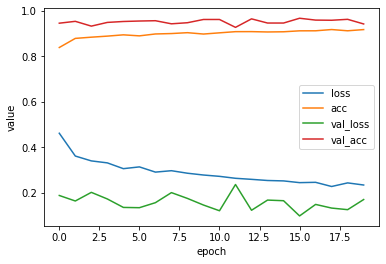

In [ ]:
make_plot(H)

In [136]:
def accuracy(model, X_test, y_test, class_name=None):
  if class_name:
    labels = lb.inverse_transform(y_test)
    indices = np.where(labels == class_name)[0]
    X_test = X_test[indices]
    y_test = y_test[indices]
  test_preds = model.predict(X_test)
  m = tf.keras.metrics.CategoricalAccuracy()
  m.update_state(y_test, test_preds)
  return m.result().numpy()

In [135]:
def classification_report(model, X_test, y_test):
  classes = list(lb.classes_)
  classes = [None] + classes
  for c in classes:
    message = 'Total accuracy:' if c is None else c + ' accuracy:'
    print(message, accuracy(model, X_test, y_test, class_name=c))

In [ ]:
classification_report(model, X_test_norm, y_test)

Total accuracy: 0.9371672
incorrect accuracy: 0.47115386
with_mask accuracy: 0.96298987
without_mask accuracy: 0.969697


**Due to the very unbalanced dataset there is a very low accuracy when classifying images with an incorrectly worn mask.**

## Weight balancing

In [ ]:
input = tf.keras.layers.Input(shape=input_shape)
out = tf.keras.layers.Conv2D(100, (3,3), activation='relu')(input)
out = tf.keras.layers.Conv2D(100, (3,3), strides=2, activation='relu')(input)
out = tf.keras.layers.Conv2D(100, (3,3), strides=2, activation='relu')(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dropout(0.5)(out)
out = tf.keras.layers.Dense(50, activation='relu')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)
model = tf.keras.models.Model(input, out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
c = Counter(lb.inverse_transform(y_train))
c

Counter({'incorrect': 416, 'with_mask': 5516, 'without_mask': 1588})

In [ ]:
sum(c.values())

7520

In [ ]:
total = sum(c.values())
incorrect = c['incorrect']
with_mask = c['with_mask']
without_mask = c['without_mask']

incorrect_weight = total/incorrect
with_mask_weight = total/with_mask
without_mask_weight = total/without_mask

classes = lb.classes_.tolist()

class_weight = {
    classes.index('incorrect') : incorrect_weight,
    classes.index('with_mask') : with_mask_weight,
    classes.index('without_mask') : without_mask_weight
}

print('Classes:', classes)
print('class_weight:',class_weight)

Classes: ['incorrect', 'with_mask', 'without_mask']
class_weight: {0: 18.076923076923077, 1: 1.3633067440174038, 2: 4.73551637279597}


In [ ]:
#training
H = model.fit(
	train_gen,
	steps_per_epoch=step_size_train,
  validation_data = valid_gen,
  validation_steps = step_size_valid,
	epochs=epochs,
  class_weight=class_weight)

Epoch 1/20
94/94 [==============================] - 12s 126ms/step - loss: 3.1660 - acc: 0.5611 - val_loss: 0.8705 - val_acc: 0.6481
Epoch 2/20
94/94 [==============================] - 11s 121ms/step - loss: 2.1496 - acc: 0.7430 - val_loss: 0.9130 - val_acc: 0.5985
Epoch 3/20
94/94 [==============================] - 11s 121ms/step - loss: 2.1559 - acc: 0.7317 - val_loss: 0.6513 - val_acc: 0.7317
Epoch 4/20
94/94 [==============================] - 12s 123ms/step - loss: 2.0025 - acc: 0.7564 - val_loss: 0.5765 - val_acc: 0.7500
Epoch 5/20
94/94 [==============================] - 11s 121ms/step - loss: 2.0282 - acc: 0.7578 - val_loss: 0.6853 - val_acc: 0.7215
Epoch 6/20
94/94 [==============================] - 11s 122ms/step - loss: 1.8128 - acc: 0.7770 - val_loss: 0.5508 - val_acc: 0.7840
Epoch 7/20
94/94 [==============================] - 11s 122ms/step - loss: 1.7948 - acc: 0.7832 - val_loss: 0.7041 - val_acc: 0.7452
Epoch 8/20
94/94 [==============================] - 12s 123ms/step - 

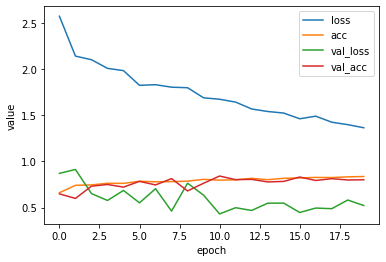

In [ ]:
make_plot(H)

In [ ]:
classification_report(model, X_test_norm, y_test)

Total accuracy: 0.8402556
incorrect accuracy: 0.8942308
with_mask accuracy: 0.82656026
without_mask accuracy: 0.8737374


## Oversampling

In [125]:
def oversample(gen, ratio, batch_size):
  while True:
    n = gen.n
    images = []
    labels = []

    sizes = [int(r * batch_size) for r in ratio]
    sum_of_sizes = sum(sizes)
    res = batch_size - sum_of_sizes
    while res > 0:
      random_class = np.random.randint(0, len(ratio), size=1)[0]
      sizes[random_class] += 1
      res -= 1
    it = 0
    while any(s != 0 for s in sizes):
      data = gen.next()
      current_images = data[0]
      current_labels = np.argmax(data[1], axis=1)
      one_hot_labels = data[1]
      for i, s in enumerate(sizes):
        if s != 0:
          indices = np.where(current_labels == i)[0]
          if len(indices) >= s:
            images.extend(current_images[indices][:s])
            labels.extend(one_hot_labels[indices][:s])
            sizes[i] = 0
          else:
            images.extend(current_images[indices])
            labels.extend(one_hot_labels[indices])
            sizes[i] -= len(indices)
    
    images = np.array(images)
    labels = np.array(labels)
    images, labels = sklearn.utils.shuffle(images, labels)
    yield images, labels

In [146]:
input = tf.keras.layers.Input(shape=input_shape)
out = tf.keras.layers.Conv2D(100, (3,3), activation='relu')(input)
out = tf.keras.layers.Conv2D(100, (3,3), strides=2, activation='relu')(input)
out = tf.keras.layers.Conv2D(100, (3,3), strides=2, activation='relu')(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dropout(0.5)(out)
out = tf.keras.layers.Dense(50, activation='relu')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)
model = tf.keras.models.Model(input, out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [140]:
lb.classes_

array(['incorrect', 'with_mask', 'without_mask'], dtype='<U12')

In [145]:
over_train_gen = oversample(train_gen, [0.43, 0.29, 0.29], 64)
over_valid_gen = oversample(train_gen, [0.43, 0.29, 0.29], 64)

In [147]:
#training
H = model.fit(
	over_train_gen,
	steps_per_epoch=step_size_train,
  validation_data = over_valid_gen,
  validation_steps = step_size_valid,
	epochs=epochs)

Epoch 1/20
94/94 [==============================] - 68s 732ms/step - loss: 0.7720 - acc: 0.6616 - val_loss: 0.5615 - val_acc: 0.7751
Epoch 2/20
94/94 [==============================] - 68s 736ms/step - loss: 0.5499 - acc: 0.7793 - val_loss: 0.4983 - val_acc: 0.8145
Epoch 3/20
94/94 [==============================] - 68s 736ms/step - loss: 0.5355 - acc: 0.7903 - val_loss: 0.4606 - val_acc: 0.8043
Epoch 4/20
94/94 [==============================] - 69s 740ms/step - loss: 0.4803 - acc: 0.8070 - val_loss: 0.4015 - val_acc: 0.8526
Epoch 5/20
94/94 [==============================] - 68s 731ms/step - loss: 0.4656 - acc: 0.8229 - val_loss: 0.4068 - val_acc: 0.8512
Epoch 6/20
94/94 [==============================] - 69s 739ms/step - loss: 0.4234 - acc: 0.8326 - val_loss: 0.3833 - val_acc: 0.8492
Epoch 7/20
94/94 [==============================] - 67s 724ms/step - loss: 0.3925 - acc: 0.8455 - val_loss: 0.3969 - val_acc: 0.8390
Epoch 8/20
94/94 [==============================] - 69s 739ms/step - 

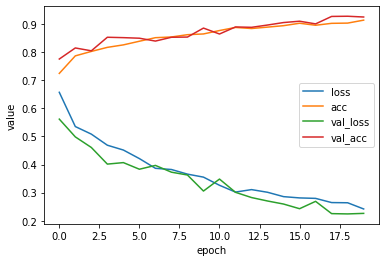

In [148]:
make_plot(H)

In [149]:
classification_report(model, X_test_norm, y_test)

Total accuracy: 0.884984
incorrect accuracy: 0.875
with_mask accuracy: 0.8773585
without_mask accuracy: 0.9141414


In [150]:
model.save_weights('/content/drive/MyDrive/MaskDetection/model.h5')